# Final project PennyLane COM-309

We start by importing the libraries. If you do not have Pennylane installed on your computer yet, please refer to the previous notebook on quantum teleportation.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

### Preliminaries

Let's define the Bell states. 

In [2]:
# Bell states (in vector form)
b_00 = [1, 0, 0, 1]/np.sqrt(2)
b_01 = [0, 1, 1, 0]/np.sqrt(2)
b_10 = [1, 0, 0, -1]/np.sqrt(2)
b_11 = [0, 1, -1, 0]/np.sqrt(2) 

### Question 1: Implement the circuit to construct Werner states.

We remind the quantum circuit that construct a Werner state. 

<img src="werner_circuit.png" alt="drawing" width="500"/>

To implement $G$ we will use the following generic architecture: 

<img src="gate_g.png" alt="drawing" width="500"/>

where the gates $R_y$ are rotation around the $Y$ axis.
This circuit allows to contruct any two qubit state. In our case, the angles $\alpha$, $\beta$ and $\gamma$ will depend on $w$ such that $G(w)\ket{00} = \sqrt{\frac{1-w}{4}}\left(\ket{00} + \ket{01}+\ket{10}\right) + \sqrt{\frac{1+3w}{4}} \ket{11}$.

We give you the function that precompute $\alpha$, $\beta$ and $\gamma$ for a given $w$. 


In [3]:
def angle_werner(w):
    p00, p01, p10  = (np.sqrt((1 - w) / 4), ) * 3
    p11 = np.sqrt((1 + 3 * w) / 4)
    alpha = np.arcsin(2 * (p00 * p11 - p01 * p10))
    c_alpha, s_alpha = np.cos(alpha / 2), np.sin(alpha / 2)

    if abs(c_alpha) <= 1e-10:
        beta = 2 * np.arctan2(p00, p10)
        return alpha, beta, 0
    
    A = 1 / np.cos(alpha) * np.array([[c_alpha * p00 - s_alpha * p11, c_alpha * p01 + s_alpha * p10],
                                      [s_alpha * p01 + c_alpha * p10, c_alpha * p11 - s_alpha * p00]])

    x = np.array([1, 1])
    b = (A @ A.T @ x / np.linalg.norm(A @ A.T @ x)).reshape(-1, 1)
    c = (A.T @ A @ x / np.linalg.norm(A.T @ A @ x)).reshape(-1, 1)
    beta = 2 * np.arctan2(b[1,0], b[0,0])
    if np.allclose(b @ c.T, A):
        gamma = 2 * np.arctan2(c[1,0], c[0,0])
    else:
        gamma = 2 * np.arctan2(-c[1,0], -c[0,0])
    
    return alpha, beta, gamma

With this function, implement the complete circuit and draw it. You should obtain a circuit similar to the first figure.

Matplotlib is building the font cache; this may take a moment.


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

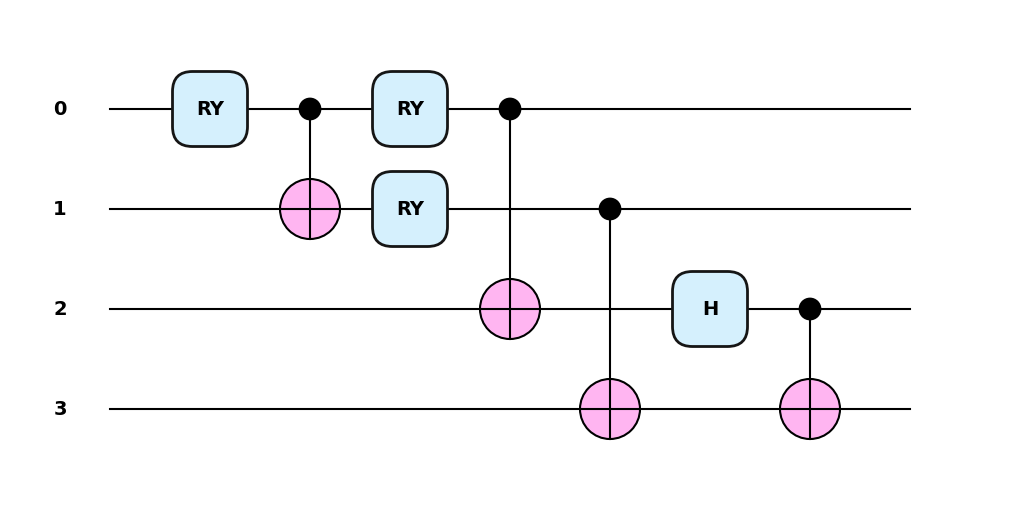

In [4]:
# Define the G gate
def G(alpha, beta, gamma):
    qml.RY(alpha, wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(beta, wires=0)
    qml.RY(gamma, wires=1)

# Define the coupling to the environment
def coupling_to_environment():
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])

# Define the Bell state preparation
def Bell_state():
    qml.Hadamard(wires=2)
    qml.CNOT(wires=[2, 3])

# Define the Werner state circuit
def werner_state(w):
    alpha, beta, gamma = angle_werner(w)
    G(alpha, beta, gamma)
    coupling_to_environment()
    Bell_state()


w = 0
qml.draw_mpl(werner_state, style="pennylane")(w)




Compute $\rho_W (w)$ by taking the partial trace over the first two qubits. 

In [5]:
dev1 = qml.device("default.qubit", wires=4)

@qml.qnode(dev1)
def density_matrix_werner(w):
    werner_state(w)
    return qml.density_matrix(wires=[2,3])

#Exemple to visualize 
# rho_w = density_matrix_werner(0.5)
# print(np.real(np.array(rho_w)))

You can test your circuit using the following cell.

In [6]:
w =1/2
rho = density_matrix_werner(w)
print(rho) 
print(f"The output is correct for w = {w}: ", np.allclose(rho,(1-w)/4*np.eye(4) + w * np.outer(b_11, b_11.conj())))

[[ 0.125+0.j  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.375+0.j -0.25 +0.j  0.   +0.j]
 [ 0.   +0.j -0.25 +0.j  0.375+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  0.125+0.j]]
The output is correct for w = 0.5:  True


### Question 2:  Apply the Peres criterion to the Werner state for $w \in [0,1]$. For which $w$ is $\rho_W (w)$ separable ?

We start by implementing the partial transpose with numpy. 

In [7]:
def partial_transpose(rho):
    rho = rho.reshape(2, 2, 2, 2)
    rho_pt = np.transpose(rho, axes=(0, 3, 2, 1))
    return rho_pt.reshape(4, 4)

#Exemple to visualize
# rho = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]])
# print(rho)
# rho_pt = partial_transpose(rho)
# print(rho_pt)


*Hint*: you can look to the documentation of the numpy transpose function.

You can check your code with the following cell.

In [8]:
A = np.arange(16)
print(f"The test is correct:", np.allclose(partial_transpose(A),np.array([[0,4,2,6],[1,5,3,7],[8,12,10,14],[9,13,11,15]])))

The test is correct: True


Complete the following cell to compute the smallest eigenvalue of $(I_{C}\otimes T_{D})\rho_W (w)$.

In [9]:
def peres_criterion(w):
    rho_w = density_matrix_werner(w)
    ITrho_W = partial_transpose(rho_w)
    eigenvalues = np.linalg.eigvalsh(ITrho_W)
    return np.min(eigenvalues)

Plot the smallest eigenvalue of $\rho_W (w)$ for $w \in [0,1]$. You should observe that $\rho_W (w)$ is entangled for $w > w_{limit}$. What is the value of $w_{limit}$?

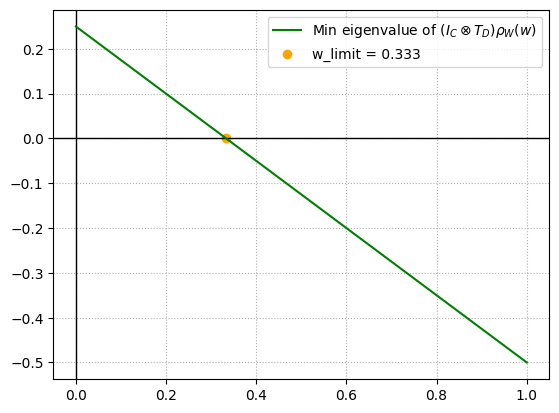

In [10]:
w = np.linspace(0,1,100)
y1 = np.array([peres_criterion(x) for x in w])

w_limit = np.argmin(np.abs(y1))

plt.axhline(y=0, lw=1, color='k')
plt.axvline(x=0, lw=1, color='k')
plt.grid(ls=":")
plt.plot(w,y1,color="green", label=r"Min eigenvalue of $(I_{C}\otimes T_{D})\rho_W (w)$")
plt.scatter(w[w_limit], y1[w_limit],color="orange",label=f"w_limit = {np.round(w[w_limit],3)}")
plt.legend()
plt.show()

### Question 3: Run the circuit to measure $\chi(w)$ for $w \in [0, 1]$ and draw plot of this dependence. 

First, we have to define the observable $\mathcal{B}$ that we would like to measure. 

In Pennylane, [`pennylane.operation.Operator`](https://docs.pennylane.ai/en/stable/introduction/operations.html) is the class to represent a quantum operator, as it is the format used for observables to measure. You can perform operations on its instances such as addition, subtraction, scalar multiplication, dot product etc. 

Note that an operator in Pennylane is instanciated with the Qubit it acts on. Thus doing the tensor product of the operator $X$ on the first qubit and $Z$ on the second qubit is simply doing the matrix multiplication $ X \otimes I \cdot I \otimes Z $.

Your task is to implement $\mathcal{B}$, represented by variable `Bell_op` using the operators `PauliX,PauliZ`.

In [11]:
Identity = qml.I(0) @ qml.I(1)
A0 = qml.X(2)
A1 = qml.Z(2)
B0 = (-qml.X(3) + qml.Z(3))/np.sqrt(2)
B1 = (-qml.X(3) - qml.Z(3))/np.sqrt(2)
Bell_op_w = A0 @ B0 + A0 @ B1 - A1 @ B0 + A1 @ B1

Bell_op = Identity @ Bell_op_w


#Example to visualize A0 @ B0
# B_mat = qml.matrix(A0 @ B0, wire_order=[2, 3])
# print(B_mat)


Compute $\chi(w)$ by computing the expectation of the observable $\mathcal{B}$ . 

In [12]:
@qml.qnode(dev1)
def Bell_operator_measurement(w):
    werner_state(w)
    return qml.expval(Bell_op)

Plot $\chi(w)$ against $w$. Compare it to Tsirelson's bound. You should observe that $Tr(\rho_W (w) \mathcal{B}) > 2 $  for $w > w_{CHSH}$. What is the value of $w_{CHSH}$?


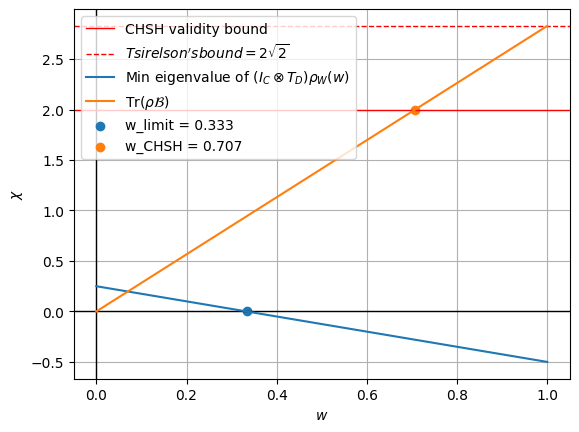

χ(w=0): -4.440892098500626e-16
χ(w=1): 2.8284271247461885


In [13]:
w = np.linspace(0,1,100)
y1 = np.array([peres_criterion(x) for x in w])
y2 = np.array([Bell_operator_measurement(x) for x in w])


w_limit = np.argmin(np.abs(y1))

w_CHSH = np.argmin(np.abs(y2-2))

plt.axhline(y=0, lw=1, color='k')
plt.axvline(x=0, lw=1, color='k')
plt.axhline(y=2, lw=1, color='r', label='CHSH validity bound')
plt.axhline(y=2 * np.sqrt(2), lw=1, color='r', ls='--', label=r"$Tsirelson's bound=2\sqrt{2}$")
plt.grid()
plt.plot(w,y1,label=r"Min eigenvalue of $(I_{C}\otimes T_{D})\rho_W (w)$")
plt.plot(w, y2,label=r'Tr($\rho \mathcal{B}$)')
plt.scatter(w[w_limit], y1[w_limit],label=f"w_limit = {np.round(w[w_limit],3)}")
plt.scatter(w[w_CHSH], y2[w_CHSH],label=f"w_CHSH = {np.round(w[w_CHSH],3)}")
plt.xlabel('$w$')
plt.ylabel('$\\chi$')
plt.legend()
plt.show()


chi_w_0 = y2[0]
print(f"\u03C7(w=0): {chi_w_0}")


chi_w_1 = y2[-1] 
print(f"\u03C7(w=1): {chi_w_1}")


## Bonus question (see Quiskit notebook)

How to run it on a real quantum computer ?

Since with the free plan, you only have 10 min per month, we detailled this question only on the quiskit notebook. However to be exhaustive, we indicate here the main idea to run a Pennylane circuit on a IBM machine. 

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="<YOUR_IBMQ_TOKEN>")

service = QiskitRuntimeService(channel="ibm_quantum", instance="my_hub/my_group/my_project")
backend = service.least_busy(n_qubits=127, simulator=False, operational=True) # request a small machine with 127 qubits

try:
    # Although we only need 4 qubits, our device has 127 qubits, therefore we initialize with wires=127
    dev = qml.device("qiskit.remote", wires=127, backend=backend)
except Exception as e:
    print(e)

@qml.qnode(dev)
def Bell_operator_measurement(w):
    werner_state(w)
    return qml.expval(Bell_op)

Bell_operator_measurement(1/np.sqrt(2))

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'